In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.dates as mdates

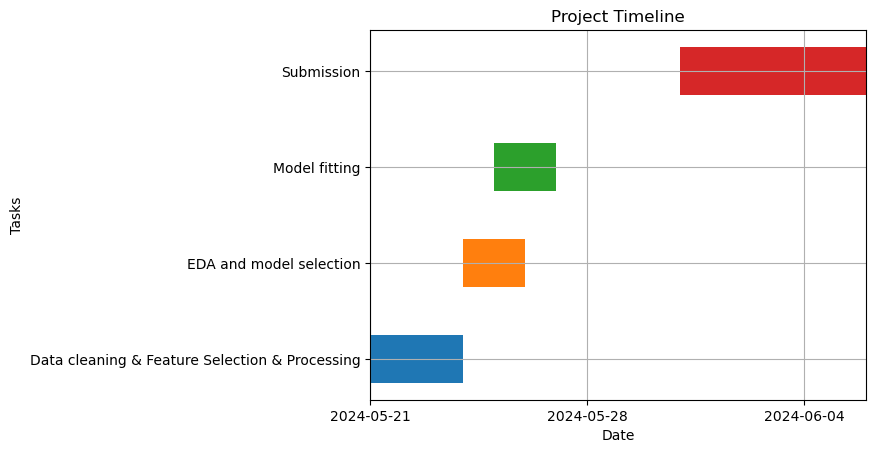

In [ ]:
# Step 2: Create the data for the Gantt chart
tasks = ['Data cleaning & Feature Selection & Processing', 'EDA and model selection', 'Model fitting', 'Submission']
start_dates = ['2024-05-21', '2024-05-24', '2024-05-25', '2024-05-31']
durations = [3, 2, 2, 6]

# Step 3: Initialize the figure and axis
fig, ax = plt.subplots()

# Step 4: Set y-axis tick labels
ax.set_yticks(np.arange(len(tasks)))
ax.set_yticklabels(tasks)

# Step 5: Plot each task as a horizontal bar
for i in range(len(tasks)):
    start_date = pd.to_datetime(start_dates[i])
    end_date = start_date + pd.DateOffset(days=durations[i])
    ax.barh(i, end_date - start_date, left=start_date, height=0.5, align='center')

# Step 6: Set x-axis limits
min_date = pd.to_datetime(min(start_dates))
max_date = pd.to_datetime(max(start_dates)) + pd.DateOffset(days=max(durations))
ax.set_xlim(min_date, max_date)

# Step 7: Customize the chart
ax.xaxis_date()
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_xlabel('Date')
ax.set_ylabel('Tasks')
ax.set_title('Project Timeline')

# Step 8: Display the chart
plt.grid(True)
plt.show()

In [ ]:
df=pd.read_csv('/Users/evaristovillasecoarribas/Desktop/sales-output-new-7.csv')

#First we remove spaces in the labels of columns
df.columns=df.columns.str.strip()

# We identify that some columns have missing seconds
print(df['Date'].iloc[170])
print(df['Date'].iloc[169])
print(df['Date'].iloc[183])

2022-10-01T13:52:25
2022-10-01T13:52
2022-10-01T14:13


In [ ]:
# use format for dates
# for the entries that fails to parse and is NaT parses them in the second format without seconds
df['Date']=pd.to_datetime(df['Date'], format='%Y-%m-%dT%H:%M:%S', errors='coerce').fillna(
    pd.to_datetime(df['Date'], format='%Y-%m-%dT%H:%M', errors='coerce'))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63637 entries, 0 to 63636
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Item Id      63637 non-null  object        
 1   Item Name    63637 non-null  object        
 2   Date         63637 non-null  datetime64[ns]
 3   Category_id  63637 non-null  object        
 4   Quantity     63637 non-null  int64         
 5   Price        63637 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 2.9+ MB


In [ ]:
import requests
from datetime import datetime


lat = 40.7128  # Latitude for New York City
lon = -74.0060  # Longitude for New York City
date = datetime(2020, 5, 23)
print( int(date.timestamp()))

def get_weather(lat,lon,date):

    API_KEY = 'b5ebb6fe9fce8a66cb525c9b6080de96'
    time = int(date.timestamp())

    #url=f'https://api.openweathermap.org/data/3.0/onecall/timemachine?lat={lat}&lon={lon}&dt={time}&appid={API_KEY}'

    url=f'https://api.openweathermap.org/data/2.5/weather?lat={lat}&lon={lon}&appid={API_KEY}&units=metric'

    response = requests.get(url)
    status=response.status_code
    if(status==200):
        return(response.json())
    else:
        return 'ERROR'

weather=get_weather(lat,lon,date)
#weather['main']['temp_min']

weather


1590192000


{'coord': {'lon': -74.006, 'lat': 40.7127},
 'weather': [{'id': 800,
   'main': 'Clear',
   'description': 'clear sky',
   'icon': '01d'}],
 'base': 'stations',
 'main': {'temp': 29.02,
  'feels_like': 27.73,
  'temp_min': 27.19,
  'temp_max': 30.84,
  'pressure': 1011,
  'humidity': 27},
 'visibility': 10000,
 'wind': {'speed': 5.14, 'deg': 310},
 'clouds': {'all': 0},
 'dt': 1716574019,
 'sys': {'type': 2,
  'id': 2008101,
  'country': 'US',
  'sunrise': 1716543085,
  'sunset': 1716596084},
 'timezone': -14400,
 'id': 5128581,
 'name': 'New York',
 'cod': 200}

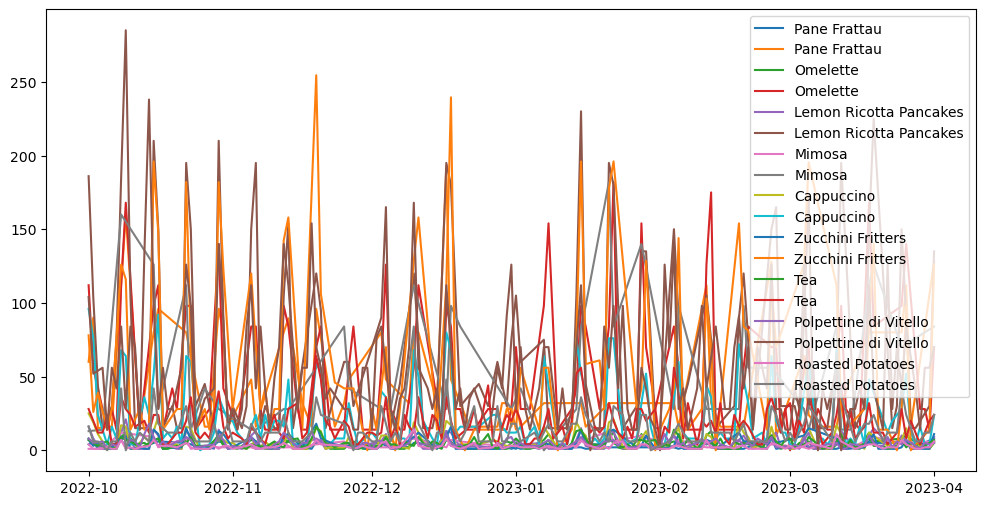

In [ ]:
categories=df['Item Name'].unique()
categories
df.sample(4)

# First we make a dictionary of dataframes per each unique category
df_dict = {category: group for category, group in df.groupby('Item Name')}

# We define a dictionary of data frames that contains the number of daily sales and total price of each element
df_daily_dict = {category: df_dict[category].groupby(df_dict[category]['Date'].dt.date)[['Quantity','Price']].sum() for category in categories}

plt.figure(figsize=(12,6))

for i in range(10):
    if categories[i] != 'Non-Cash ADJ':
        plt.plot(df_daily_dict[categories[i]].index,df_daily_dict[categories[i]].values,label=categories[i])
        plt.legend()
plt.show()





(0.0, 100.0)

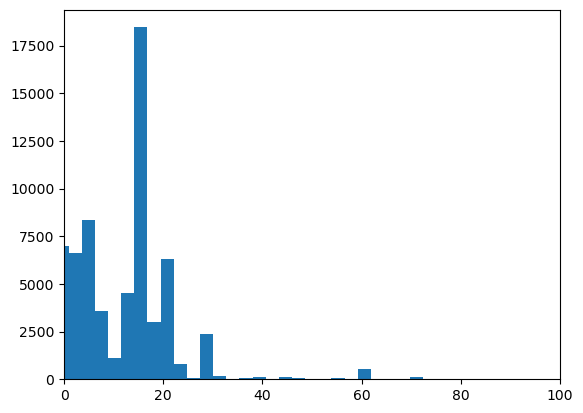

In [ ]:
plt.hist(df['Price'],bins=100)
plt.xlim(0,100)

In [ ]:
from datetime import datetime
from meteostat import Point, Daily

location = Point(40.7128, -74.0060)

# Define time period
start_date=df_daily_dict['Asparagus Salad'].index[0]
end_date=df_daily_dict['Asparagus Salad'].index[-1]

start = datetime(start_date.year, start_date.month, start_date.day)
end = datetime(end_date.year, end_date.month, end_date.day)

# Get daily data for the defined location and period
data = Daily(location, start, end)
data = data.fetch()
data

# This function will convert from datetime to date
def modify_index(index_value):
        return index_value.date()

# Apply the function to the indices and then drop columns with NaNs
data.index = data.index.map(modify_index)
data.drop(['wpgt','tsun','tmax','tmin','wdir','snow','pres','wspd'], axis=1, inplace=True)

new_dict={category: df_daily_dict[category].merge(data, how='left', left_index=True, right_index=True) for category in categories}


#plt.scatter(new_dict['Iced Tea']['tavg'],new_dict['Iced Tea']['Quantity'])
#plt.xlabel('Average temperature')
#plt.ylabel('Quantity Sold')
#plt.show()

# Date, quantity, price, tavg, rain/norain, week/weekend, holiday/no holiday

# Useful functions

In [ ]:
import holidays

us_holidays = holidays.US()

def is_weekend(date):
    if date.weekday()==5 or date.weekday()==6:
        return True
    else:
        return False

def is_rain(prec):
    if prec==0.0:
        return False
    else:
        return True

def is_holiday(date_h):
    return date_h in us_holidays


for category in categories:
    new_dict[category]['Weekend']=new_dict[category].index.map(is_weekend)
    new_dict[category]['Rain']=new_dict[category]['prcp'].map(is_rain)
    new_dict[category]['Holiday']=new_dict[category].index.map(is_holiday)

new_dict['Aperol Spritz']


,Quantity,Price,tavg,prcp,Weekend,Rain,Holiday
Date,,,,,,,
2022-10-01,12,141.4,14.4,33.3,True,True,False
2022-10-02,1,14.0,13.9,7.5,True,True,False
2022-10-03,1,15.0,10.7,9.0,False,True,False
2022-10-04,1,15.0,11.3,71.4,False,True,False
2022-10-06,2,15.0,16.2,0.0,False,False,False
...,...,...,...,...,...,...,...
2023-03-25,39,585.0,6.6,10.2,True,True,False
2023-03-26,1,15.0,11.4,0.0,True,False,False
2023-03-30,1,15.0,5.0,0.0,False,False,False


In [ ]:

import holidays

us_holidays = holidays.US()

def is_holiday(date_h):
    return date_h in us_holidays







In [ ]:
from datetime import date
import holidays

us_holidays = holidays.US()

date(2015, 1, 1) in us_holidays , date(2015, 1, 2) in us_holidays  # False



(True, False)